[*********************100%%**********************]  1 of 1 completed
Current price is: $424.5
The drift coefficient is: -0.0005309739118936086 
The volatility is: 0.005211248135412849


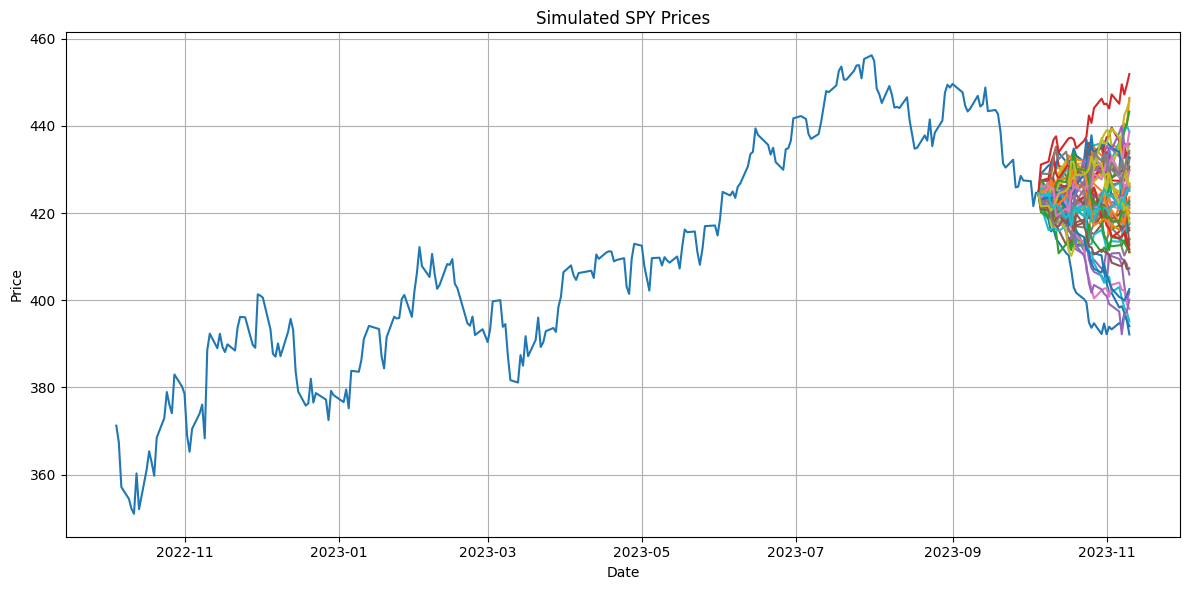

In [316]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

STOCK_SYMBOL = "SPY" # Define the stock symbol
NUM_ITERATIONS = 59  # Number of GBM simulations to perform
TIME_HORIZON = 26 # Define the time horizon for the simulation (in trading days)
if NUM_ITERATIONS > 15:
    LEGEND_STATE = False
else:
    LEGEND_STATE = True

# Fetch historical stock data
end_date = pd.Timestamp.today()
stock_data = yf.download(STOCK_SYMBOL, end=end_date)
# Extract the most recent closing price
current_price = stock_data['Adj Close'][-1]
print(f"Current price is: ${np.round(current_price, decimals=2)}")
# Calculate daily returns (log returns)
log_returns = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1)).dropna()

# Calculate the mean and standard deviation of daily log returns
mean_return = -0.0005309739118936086 #log_returns[-50:].mean()
std_deviation = 0.005211248135412849 #log_returns[-50:].std()
print(f"The drift coefficient is: {mean_return} \nThe volatility is: {std_deviation}")

# Initialize arrays to store simulated prices
simulated_prices = np.zeros((NUM_ITERATIONS, TIME_HORIZON + 1))
# Perform GBM simulations
for i in range(NUM_ITERATIONS):
    # Generate random shocks (standard normal) for the time horizon
    random_shocks = np.random.normal(0, 1, TIME_HORIZON)
    # Calculate the simulated price path
    price_path = np.zeros(TIME_HORIZON + 1)
    price_path[0] = current_price
    for j in range(1, TIME_HORIZON + 1):
        price_path[j] = price_path[j - 1] * np.exp((mean_return - (std_deviation ** 2) / 2) + std_deviation * random_shocks[j - 1])
    simulated_prices[i, :] = price_path
simulated_prices_df = pd.DataFrame(simulated_prices).T
simulated_prices_df = simulated_prices_df.set_index(pd.date_range(start=pd.to_datetime(stock_data.index[-1]), periods = TIME_HORIZON+1, freq = 'b'))
#simulated_prices_df = simulated_prices_df[simulated_prices_df.index.dayofweek < 5]

# Plot the previous month's daily stock prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-252:], stock_data['Adj Close'][-252:])
plt.plot(simulated_prices_df)
plt.title(f"Simulated {STOCK_SYMBOL} Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
if LEGEND_STATE == True:
    plt.legend(simulated_prices_df.columns)
plt.tight_layout()
plt.show()

In [392]:

#options_data_expiry_time = end_date + pd.Timedelta(TIME_HORIZON, "d")
options_data_expiry_time = simulated_prices_df[0].index[-1].strftime('%Y-%m-%d')
options_data_expiry_delta = simulated_prices_df[0].index[-1] - simulated_prices_df[0].index[0]

STRIKE_PRICE = 425
CALL_OR_PUT = "put"

options_data = yf.Ticker(STOCK_SYMBOL).option_chain(options_data_expiry_time)

if CALL_OR_PUT == 'call':
    calls = options_data.calls
    option_compare_data = calls[calls['strike'] == STRIKE_PRICE]
elif CALL_OR_PUT == 'put':
    puts = options_data.puts
    option_compare_data = puts[puts['strike'] == STRIKE_PRICE]
print(f"Showing results for ${STRIKE_PRICE} {CALL_OR_PUT}s {options_data_expiry_delta.days} day(s) to expire ({options_data_expiry_time})")
option_compare_data

Showing results for $425 puts 36 day(s) to expire (2023-11-10)


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
33,SPY231110P00425000,2023-10-05 20:01:49+00:00,425.0,8.06,8.2,8.23,-0.089999,-1.104285,578,1172,0.149972,True,REGULAR,USD


In [393]:
import numpy as np
from scipy.stats import norm #importing the normal distribution function only 

#call price function, sigma=volatility(σ)
def BSM_call_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T)) 
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2) 

#put price function, sigma = volatility(σ)
def BSM_put_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)


Showing results for $425 puts 36 day(s) to expire
              0      1     2      3     4     5      6     7     8     9   \
2023-10-05  1.37   1.37  1.37   1.37  1.37  1.37   1.37  1.37  1.37  1.37   
2023-10-06  1.18   1.36  0.91   1.56  0.94  1.93   1.90  1.51  1.65  0.72   
2023-10-09  1.56   1.24  0.86   1.40  0.93  2.15   1.20  1.05  1.07  0.53   
2023-10-10  1.74   1.04  0.47   1.65  1.50  2.10   1.16  0.80  2.11  0.50   
2023-10-11  2.30   1.03  0.35   1.59  0.75  2.79   1.23  0.45  1.62  0.40   
2023-10-12  2.17   1.03  0.24   2.37  0.58  2.38   2.56  0.53  1.13  0.57   
2023-10-13  1.19   1.06  0.54   2.52  0.56  3.84   2.40  0.59  1.41  0.30   
2023-10-16  1.56   1.37  0.57   5.00  0.78  3.60   4.13  0.52  1.35  0.44   
2023-10-17  1.38   2.25  0.66   7.27  1.22  2.91   4.10  0.93  1.81  0.45   
2023-10-18  1.45   2.39  0.74   5.60  1.29  2.88   3.17  0.67  1.61  0.37   
2023-10-19  1.13   2.17  0.66   7.37  0.63  3.12   4.17  0.86  0.91  0.22   
2023-10-20  0.31   1.55  1

<Axes: >

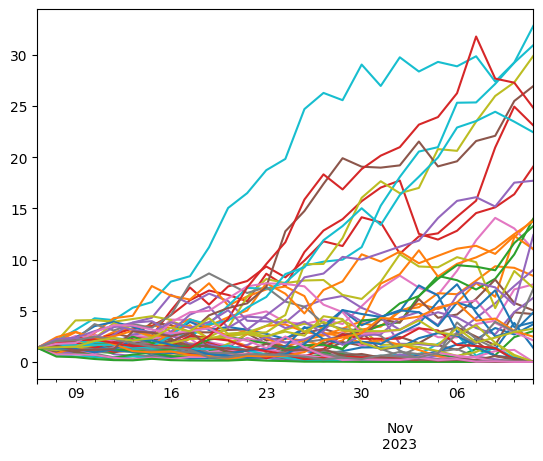

In [394]:
import warnings

option_price_index = pd.date_range(start = simulated_prices_df.index[0], end = simulated_prices_df.index[-1], freq = 'b')
option_price_df = pd.DataFrame(index=option_price_index )
annualized_vol = std_deviation * np.sqrt(252)

for sim_index in simulated_prices_df:
    trajectory = simulated_prices_df[sim_index]
    expiry_delta = simulated_prices_df[0].index[-1] - simulated_prices_df[0].index
    expiry_time_annualized = expiry_delta.days / 252
    if CALL_OR_PUT is "call":
        option_price_trajectory = BSM_call_price(trajectory, STRIKE_PRICE, expiry_time_annualized, 0.2, annualized_vol)
    elif CALL_OR_PUT is "put":
        option_price_trajectory = BSM_put_price(trajectory, STRIKE_PRICE, expiry_time_annualized, 0.2, annualized_vol)
    option_price_df[sim_index] = np.round(option_price_trajectory, decimals = 2)
print(f"Showing results for ${STRIKE_PRICE} {CALL_OR_PUT}s {expiry_delta.days[0]} day(s) to expire")
print(option_price_df)
warnings.simplefilter('ignore')
option_price_df.plot(legend = LEGEND_STATE)

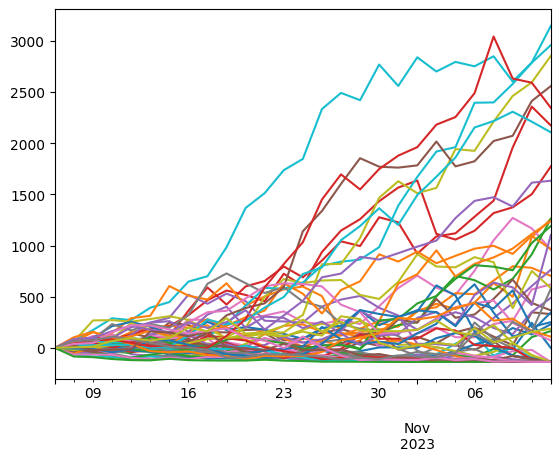

In [395]:
pnl_df = option_price_df.sub(option_price_df.iloc[0], axis=1)*100
min_pnl = pnl_df.min().min()
pnl_df.plot(legend = LEGEND_STATE)
plt.axhline(0, color='black')
plt.axhline(min_pnl, color='red')

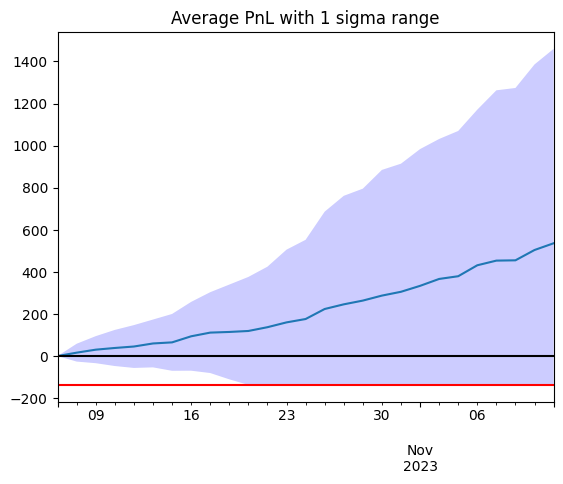

In [396]:
avg_pnl_df = pd.DataFrame(index=pnl_df.index)
avg_pnl_df["Average PnL"] = pnl_df.mean(axis=1)
avg_pnl_df["Upper Bound"] = avg_pnl_df["Average PnL"].add(1*pnl_df.std(axis=1))
avg_pnl_df["Lower Bound"] = avg_pnl_df["Average PnL"].sub(1*pnl_df.std(axis=1)).clip(lower = min_pnl)

d = avg_pnl_df.index

ax = avg_pnl_df["Average PnL"].plot(title = "Average PnL with 1 sigma range", legend = LEGEND_STATE)
ax.fill_between(d, avg_pnl_df["Average PnL"], avg_pnl_df["Upper Bound"],
                 facecolor='blue', alpha=0.2, interpolate=True)
ax.fill_between(d, avg_pnl_df["Average PnL"], avg_pnl_df["Lower Bound"],
                 where=avg_pnl_df["Lower Bound"] >= min_pnl,
                 facecolor='blue', alpha=0.2, interpolate=False)
ax.axhline(0, color='black')
ax.axhline(min_pnl, color='red')